In [12]:
# notebook last tested with abtem version 1.0.0beta7

from abtem import __version__
print('current version:', __version__)

from pymatgen.ext.matproj import MPRester
from pymatgen.io.ase import AseAtomsAdaptor
from abtem import *
from abtem.visualize.mpl import show_atoms

from abtem.structures import standardize_cell
from ase.visualize import view

current version: 1.0.0beta7


# Integration with the Materials projects

We import the structure directly from the [materials project](https://materialsproject.org/). The structure is reshaped to the desired zone axis using ASE and used as input in a multislice simulation.

To obtain a new structure yourself, you need an API key for the materials project, see [website](https://materialsproject.org/open).

To find the materials id of a structure (the "mp-XXXXX" string below), go to the materials project and search for a material using the online search tool.

In [3]:
api_key = '2UO9SrVM0B5engft'
with MPRester(api_key) as m:
    results = m.query('mp-22491', ['structure'])        

Connection established to Materials Project database, version 2020_09_08.


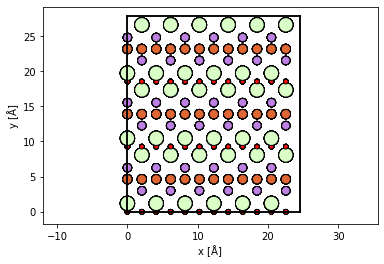

In [4]:
atoms = AseAtomsAdaptor().get_atoms(results[0]['structure'])

atoms.rotate(90, 'x', rotate_cell=True)

atoms = standardize_cell(atoms)
atoms *= (6, 3, 16)

show_atoms(atoms)

In [5]:
potential = Potential(atoms, sampling=.04)

In [6]:
S = SMatrix(energy=80e3, expansion_cutoff=30, semiangle_cutoff=30, interpolation=2, device='gpu', storage='gpu')

S.ctf.defocus = 60
S.ctf.focal_spread = 90
S.grid.match(potential)

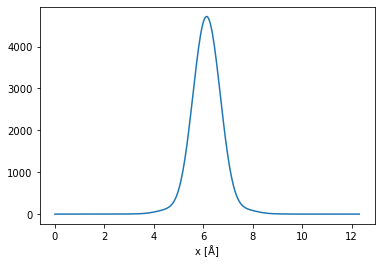

In [10]:
S.profile().show();

In [8]:
end = (potential.extent[0] / 6, potential.extent[1] / 3)

scan = GridScan((0,0), end, sampling=S.ctf.nyquist_sampling * .9)

detector = FlexibleAnnularDetector()

measurements = S.scan(scan, [detector], potential)

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x1deaf4aadc0>)

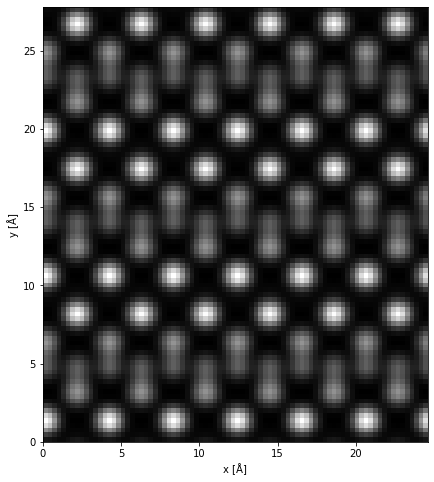

In [11]:
measurements[detector].integrate(70, 200).tile((6, 3)).show(figsize = (8, 8))